In [3]:
import os
import matplotlib.image as img 
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [5]:
def process_data(folder): 
    gender = "";                                
    images = []; 
    for subdir, dirs, files in os.walk(folder):
        if("male" in subdir):
            if ("female" in subdir):
                gender = "female"
            else:
                gender = "male"
        for f in files:
            d = {};
            img = cv2.imread(os.path.join(subdir,f))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img/255.0, (256, 256))
                d["name"] = f
                d["gender"] = gender
                d["image"] = img
                images.append(d)
    return images


path = "./data/faceScrubImg"
img_info = process_data(path)

In [6]:
counter = 0;
for i in img_info:
    if i["gender"] == "male":
        counter += 1
print(counter)

print(img_info[1]["image"].shape)

3791
(256, 256, 3)


In [7]:
labels = ["male", "female"]

labels = ["male", "female"]
images = []
all_labels = []
for info in img_info:
    images.append(info["image"])
    all_labels.append(labels.index(info["gender"]))

images = np.array(images)
all_labels = np.array(all_labels)
print(all_labels.shape)
all_labels = all_labels.reshape(15151, 1)

(15151,)


In [8]:
print(images.shape)

(15151, 256, 256, 3)


In [10]:
image_smote = images.reshape(15151, 256*256*3)

In [11]:
sm = SMOTE()

In [ ]:
image_smote, label_smote = sm.fit_resample(image_smote, all_labels)

In [ ]:
print(label_smote.shape)
# label_smote = label_smote.reshape(5320, 1)

In [8]:
train_images, test_images, train_labels, test_labels = train_test_split(image_smote, label_smote, train_size=0.5,test_size=0.5, stratify=label_smote)


In [ ]:
from collections import Counter
count = []
print(train_images.shape)
for t in train_labels:
    count.append(t[0])
print(Counter(count))
# train_images = train_images.reshape(2660, 200, 180, 3)
# train_labels = train_labels.reshape(2660, 1)
# test_images = test_images.reshape(2660, 200, 180, 3)
# test_labels = test_labels.reshape(2660, 1)

In [9]:
# print what percentage of males vs females
num_females = 0;
counter = 0;
for g in train_labels:
    num_females = g[0] + num_females
    
print("Percentage of females in training data set:", (num_females/(len(train_labels)))*100)

Percentage of females in training data set: 48.58876285940385


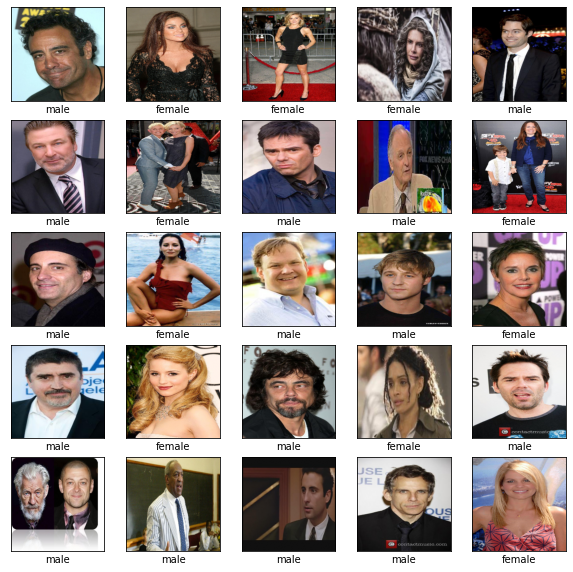

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(labels[train_labels[i][0]])
plt.show()

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(96, (11, 11), activation='relu', input_shape=(256, 256, 3), strides=(4, 4)))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(256, (5, 5), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(layers.Conv2D(384, (3, 3), activation='relu', padding ='same'))
model.add(layers.Conv2D(384, (3, 3), activation='relu', padding ='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding ='same'))
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(2))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 222784)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
119/119 [==============================] - 152s 1s/step - loss: 0.6569 - accuracy: 0.6893 - val_loss: 0.8194 - val_accuracy: 0.5141
Epoch 2/10
119/119 [==============================] - 128s 1s/step - loss: 0.5161 - accuracy: 0.7436 - val_loss: 0.9966 - val_accuracy: 0.5123
Epoch 3/10
119/119 [==============================] - 119s 1s/step - loss: 0.4022 - accuracy: 0.8201 - val_loss: 1.2188 - val_accuracy: 0.5067
Epoch 4/10
119/119 [==============================] - 121s 1s/step - loss: 0.2752 - accuracy: 0.8826 - val_loss: 1.7078 - val_accuracy: 0.5059
Epoch 5/10
119/119 [==============================] - 121s 1s/step - loss: 0.1645 - accuracy: 0.9367 - val_loss: 2.1986 - val_accuracy: 0.5022
Epoch 6/10
119/119 [==============================] - 121s 1s/step - loss: 0.0798 - accuracy: 0.9707 - val_loss: 3.0365 - val_accuracy: 0.5036
Epoch 7/10
119/119 [==============================] - 121s 1s/step - loss: 0.0447 - accuracy: 0.9844 - val_loss: 3.8703 - val_accuracy: 0.5083

119/119 - 25s - loss: 3.7213 - accuracy: 0.5059


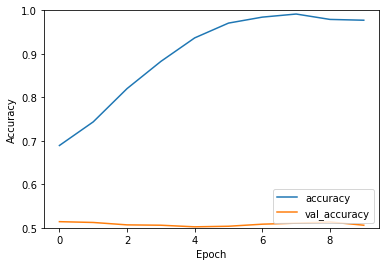

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [17]:
print(test_acc)

0.5059351325035095
